In [ ]:
%pip install datasets transformers[sentencepiece]

In [2]:
# downloads
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [3]:
# imports
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
import os
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset, DatasetDict, load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification

In [4]:
print("Num of GPUs:", len(tf.config.list_physical_devices("GPU")))

Num of GPUs: 2


In [5]:
# we'll use the smaller 20k dataset
data_path = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# check all text files contained in data path
text_files = [data_path + text_file for text_file in os.listdir(data_path)]
text_files

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [7]:
# create a function to reformat our data
def reformat_data(text_file):
    with open(text_file, "r") as f:
        text_data = f.readlines()
    
    # text_data = read_data(text_file)
    text_obj = ""
    text_list = []

    for txt in text_data:
        if txt.startswith("###"):
            text_obj = ""
        elif txt.isspace():
            text_obj_splt = text_obj.splitlines()

            for idx, txt_obj in enumerate(text_obj_splt):
                dict_obj = {}
                dict_splt = txt_obj.split("\t")
                dict_obj["label"] = dict_splt[0]
                dict_obj["text"] = dict_splt[1]
                dict_obj["line"] = idx
                dict_obj["total"] = len(text_obj_splt)-1
                text_list.append(dict_obj)

        else:
            text_obj += txt
        
    return text_list


In [8]:
# reformat data
train_data = reformat_data(data_path+"train.txt")
val_data = reformat_data(data_path+"dev.txt")
test_data = reformat_data(data_path+"test.txt")

In [9]:
# data analysis using dataframes
df_train = pd.DataFrame(train_data)
df_val = pd.DataFrame(val_data)
df_test = pd.DataFrame(test_data)
df_train.head(15)

label                                               text  line  \
0     OBJECTIVE  To investigate the efficacy of @ weeks of dail...     0   
1       METHODS  A total of @ patients with primary knee OA wer...     1   
2       METHODS  Outcome measures included pain reduction and i...     2   
3       METHODS  Pain was assessed using the visual analog pain...     3   
4       METHODS  Secondary outcome measures included the Wester...     4   
5       METHODS  Serum levels of interleukin @ ( IL-@ ) , IL-@ ...     5   
6       RESULTS  There was a clinically relevant reduction in t...     6   
7       RESULTS  The mean difference between treatment arms ( @...     7   
8       RESULTS  Further , there was a clinically relevant redu...     8   
9       RESULTS  These differences remained significant at @ we...     9   
10      RESULTS  The Outcome Measures in Rheumatology Clinical ...    10   
11  CONCLUSIONS  Low-dose oral prednisolone had both a short-te...    11   
12   BACKGROUND  Emotional eating is associated with overeating...     0   
13   BACKGROUND  Yet , empirical evidence for individual ( trai...     1   
14    OBJECTIVE  The aim of this study was to test if attention...     2   

    total  
0      11  
1      11  
2      11  
3      11  
4      11  
5      11  
6      11  
7      11  
8      11  
9      11  
10     11  
11     11  
12     10  
13     10  
14     10

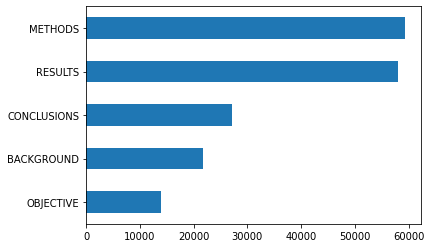

In [10]:
# check labels distribution
df_train["label"].value_counts(ascending=True).plot.barh();

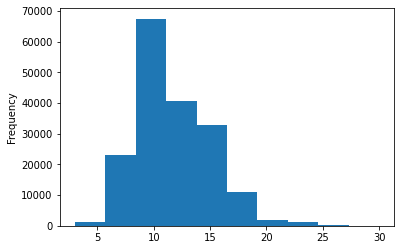

In [11]:
# check lenght distribution of our abstracts
df_train.total.plot.hist();

In [12]:
class_names = dict((i,j) for i,j in enumerate(df_train['label'].unique()))

In [13]:
# replace labels
classes = dict([(k, v) for v, k in class_names.items()])
df_train = df_train.replace(classes)
df_val = df_val.replace(classes)
df_test = df_test.replace(classes)

In [14]:
# build our abstracts
abstracts = DatasetDict({
"train": Dataset.from_pandas(df_train.reset_index(drop=True)),
"val": Dataset.from_pandas(df_val.reset_index(drop=True)),
"test": Dataset.from_pandas(df_test.reset_index(drop=True))})

In [15]:
# creating tokenizer
ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(ckpt)

In [16]:
# tokenizing our data
def tokenize(data):
    return tokenizer(data["text"], truncation=True)

abstracts_encoded = abstracts.map(tokenize, batched=True)

100%|██████████| 31/31 [00:01<00:00, 22.72ba/s]


In [17]:
# create a collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [18]:
# create datasets 
train_dataset = abstracts_encoded["train"].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols=["label"], shuffle=True, collate_fn=data_collator, batch_size=8,
    )

val_dataset = abstracts_encoded["val"].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols=["label"], shuffle=False, collate_fn=data_collator, batch_size=8,
    )

test_dataset = abstracts_encoded["test"].to_tf_dataset(
    columns=tokenizer.model_input_names, label_cols=["label"], shuffle=False, collate_fn=data_collator, batch_size=8,
    )

In [19]:
# # check input ids
# for data in list(map(lambda i: i[0],train_dataset)):
#     break
# {k: v.shape for k, v in data.items()}

In [20]:
# # set params
# epochs = 4
# decay_steps = len(train_dataset) * epochs
# lr_scheduler = PolynomialDecay(
#     initial_learning_rate=5e-5,
#     end_learning_rate=0.0,
#     decay_steps=decay_steps,
# )

In [21]:
# # create model
# model = TFAutoModelForSequenceClassification.from_pretrained(ckpt, num_labels=5)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [22]:
# # compile
# model.compile(
#     optimizer=Adam(learning_rate=lr_scheduler),
#     loss=SparseCategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"],
# )

In [23]:
# # fit
# history_trans = model.fit(
#     train_dataset,
#     steps_per_epoch=int(0.1 * len(train_dataset)),
#     epochs = epochs,
#     validation_data=val_dataset,
#     validation_steps=int(0.1 * len(val_dataset)),
#     )

Epoch 1/4
2250/2250 [==============================] - 559s 245ms/step - loss: 0.5570 - accuracy: 0.7961 - val_loss: 0.4413 - val_accuracy: 0.8362
Epoch 2/4
2250/2250 [==============================] - 719s 320ms/step - loss: 0.4545 - accuracy: 0.8357 - val_loss: 0.4029 - val_accuracy: 0.8475
Epoch 3/4
2250/2250 [==============================] - 697s 310ms/step - loss: 0.4395 - accuracy: 0.8415 - val_loss: 0.4091 - val_accuracy: 0.8372
Epoch 4/4
2250/2250 [==============================] - 787s 350ms/step - loss: 0.4289 - accuracy: 0.8454 - val_loss: 0.4134 - val_accuracy: 0.8495


In [25]:
# # save model
# model.save_pretrained("saved/model_1")

In [26]:
# # evaluate model
# preds_probs = model.predict(test_dataset)["logits"]
# y_pred = tf.argmax(preds_probs, axis=1)
# y_true = tf.transpose(list(itertools.chain(*list(map(lambda i: i[1], test_dataset)))))
# model_accuracy = accuracy_score(y_true, y_pred) * 100
# model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
# print(f"model accuracy: {model_accuracy}", f"\nmodel precision: {model_precision}",f"\nmodel recall: {model_recall}", f"\nmodel f1: {model_f1}")

model accuracy: 84.25750788120126 
model precision: 0.8557122753160681 
model recall: 0.8425750788120127 
model f1: 0.8354099835267214


### results of model evaluation metrics

model accuracy: 84.25750788120126 <br>
model precision: 0.8557122753160681 <br>
model recall: 0.8425750788120127 <br>
model f1: 0.8354099835267214<br>

In [28]:
# load model
model1 = TFAutoModelForSequenceClassification.from_pretrained("saved/model_1")

Some layers from the model checkpoint at saved/model_1 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved/model_1 and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# evaluate loaded model metrics
preds_probs = model1.predict(test_dataset)["logits"]
y_pred = tf.argmax(preds_probs, axis=1)
y_true = tf.transpose(list(itertools.chain(*list(map(lambda i: i[1], test_dataset)))))
model_accuracy = accuracy_score(y_true, y_pred) * 100
model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
print(f"model accuracy: {model_accuracy}", f"\nmodel precision: {model_precision}",f"\nmodel recall: {model_recall}", f"\nmodel f1: {model_f1}")

model accuracy: 84.25750788120126 
model precision: 0.8557122753160681 
model recall: 0.8425750788120127 
model f1: 0.8354099835267214


In [41]:
# making 10 random samples
test_abstracts = df_test[["text", "label"]]
test_abstracts_rand = test_abstracts.sample(10)
test_abstracts_rand["label"] = test_abstracts_rand["label"].map(lambda name:class_names[name])
test_abstracts_rand

text        label
28310  Although radiotherapy is a key component of cu...   BACKGROUND
22421  Cystone can protect cancer patients from cispl...  CONCLUSIONS
160    Pleurodesis failure is defined as the need for...      METHODS
4663   The multinational EUropean Patient Survey in A...   BACKGROUND
11595  The two intervention groups reported significa...      RESULTS
27333  In cohort @ , there was a statistically signif...      RESULTS
18567  This article describes a two-arm Cluster Rando...   BACKGROUND
20503  Previous studies have reported the cardioprote...   BACKGROUND
23559  The outcome measure was parental report of cha...      METHODS
7258   cotrimoxazole containing catheter lock solutio...  CONCLUSIONS

In [42]:
# making predictions using random samples
for i,j in test_abstracts_rand.iterrows():
    abstracts = {j['label']: j['text']}
    for label,text in abstracts.items():
        abstract = tf.data.Dataset.from_tensor_slices(dict(tokenizer(text, truncation=True, return_tensors="tf")))
        pred_prob = model1.predict(abstract)["logits"]
        preds = np.argmax(pred_prob, axis=1)
        print(f"Abstract:\n{text}\n")
        print(f"Predected label: {class_names[int(preds)]}, Actual label: {label}")
        print("=======\n")

Abstract:
Although radiotherapy is a key component of curative-intent treatment for locally advanced , unresectable non-small cell lung cancer ( NSCLC ) , it can be associated with substantial pulmonary toxicity in some patients .

Predected label: BACKGROUND, Actual label: BACKGROUND

Abstract:
Cystone can protect cancer patients from cisplatin nephrotoxicity without interfering with its antitumor activity .

Predected label: CONCLUSIONS, Actual label: CONCLUSIONS

Abstract:
Pleurodesis failure is defined as the need for further pleural intervention for fluid management on the side of the trial intervention .

Predected label: METHODS, Actual label: METHODS

Abstract:
The multinational EUropean Patient Survey in Atrial Fibrillation ( EUPS-AF ) was conducted to investigate patient satisfaction with AF management in different of five European healthcare systems at a time of changing treatment paradigms for stroke prophylaxis , prior to the advent of newer oral anticoagulants .

Predecte